In [1]:
#import required packages
import numpy as np
import random
import matplotlib.pyplot as plt
import gzip
import pickle

In [2]:
# Activation funciton
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z):
    return np.maximum(0, z)

def relu_prime(z):
    return np.where(z > 0, 1, 0)

In [3]:
#Cost function
class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        """Return the cross entropy cost function"""
        return np.sum(np.nan_to_num(-y*np.log(a) - (1-y)*np.log(1-a)))
    
    def delta(z, a, y):
        """Return the error from the output layer"""
        return (a-y)

In [4]:
class Network(object):
    """A neural network class"""
    
    def __init__(self, sizes, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.cost = cost
    
    def feedforward(self, a):
        """Return the output of the network if 'a' is an input"""
        
        for b, w in zip(self.biases, self.weights):
            a = relu(np.dot(w, a) + b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, lmbda=0.0, evaluation_data=None, monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False, monitor_training_cost=False, monitor_training_accuracy=False):
        """Train neural network using mini-batch stochastic gradient descent.
        The 'training_data' is a list of tuples '(x, y)' representing the training inputs
        and the desired outputs. If 'test_data' is provided then the network will be evaluated
        against the test data after each epoch, and partial progress printed out."""
       
        if evaluation_data:
            n_data = len(evaluation_data)   
        n = len(training_data)
        self.evaluation_cost, self.evaluation_accuracy = [], []
        self.training_cost, self.training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, len(training_data))
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                self.training_cost.append(cost)
                print (f"Cost on training data: {cost}")
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)/n
                self.training_accuracy.append(accuracy)
                print (f"Accuracy on training data: {accuracy}")
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                self.evaluation_cost.append(cost)
                print (f"Cost on evaluation data: {cost}")
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)/n_data 
                self.evaluation_accuracy.append(accuracy)
                print (f"Accuracy on evaluation data: {accuracy}")
                
            print(f"Epoch {j} complete \n")
        
                
    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """update network's weights and biases by applying gradient descent using backpropagation
        to a single minibatch."""
        X = np.column_stack([x for x, y in mini_batch])
        Y = np.column_stack([y for x, y in mini_batch])
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        #feedforward
        activation = X
        activations =[X]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = relu(z)
            activations.append(activation)
            
        #backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], Y)
        nabla_b[-1] = np.sum(delta, axis=1, keepdims=True)
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = relu_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = np.sum(delta, axis=1, keepdims=True)
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    
        self.weights = [(1 - eta * (lmbda/n)) * w - (eta/len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta/len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
    
    def accuracy(self, data, convert=False):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else: 
            results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)
    
    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            
            if convert: 
                e = np.zeros((10, 1))
                e[y] = 1.0
                y=e
                
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5 * (lmbda/len(data)) * sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost

In [5]:
# Function to load the MNIST dataset
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    return training_data, validation_data, test_data

# Function to preprocess the data
def preprocess_data(training_data, validation_data, test_data):
    training_inputs = [np.reshape(x, (784, 1)) for x in training_data[0]]
    training_results = [vectorized_result(y) for y in training_data[1]]
    training_data = list(zip(training_inputs, training_results))
    
    validation_inputs = [np.reshape(x, (784, 1)) for x in validation_data[0]]
    validation_data = list(zip(validation_inputs, validation_data[1]))
    
    test_inputs = [np.reshape(x, (784, 1)) for x in test_data[0]]
    test_data = list(zip(test_inputs, test_data[1]))
    
    return training_data, validation_data, test_data

# Helper function to convert digit (0-9) into a 10-dimensional unit vector
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

# Load and preprocess the data
training_data, validation_data, test_data = load_data()
training_data, validation_data, test_data = preprocess_data(training_data, validation_data, test_data)

In [9]:
# training the neural network
net = Network([784, 30, 10])
training_costs = []
net.SGD(training_data, 60, 10, 0.1, evaluation_data=validation_data, lmbda=5, monitor_evaluation_accuracy=True, monitor_training_accuracy=True,
                monitor_evaluation_cost=True,
                monitor_training_cost=True)

/var/folders/hd/mlvd77cj3kj7hwvxj8799rtr0000gn/T/ipykernel_69722/393123191.py:6: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.nan_to_num(-y*np.log(a) - (1-y)*np.log(1-a)))
/var/folders/hd/mlvd77cj3kj7hwvxj8799rtr0000gn/T/ipykernel_69722/393123191.py:6: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.nan_to_num(-y*np.log(a) - (1-y)*np.log(1-a)))
/var/folders/hd/mlvd77cj3kj7hwvxj8799rtr0000gn/T/ipykernel_69722/393123191.py:6: RuntimeWarning: invalid value encountered in log
  return np.sum(np.nan_to_num(-y*np.log(a) - (1-y)*np.log(1-a)))


Cost on training data: 2.3801457105576698e+306
Accuracy on training data: 0.94056
Cost on evaluation data: 2.3010472126237604e+306
Accuracy on evaluation data: 0.9435
Epoch 0 complete 

Cost on training data: 1.804883907401752e+306
Accuracy on training data: 0.95128
Cost on evaluation data: 2.0134163110457916e+306
Accuracy on evaluation data: 0.9525
Epoch 1 complete 

Cost on training data: 1.5172530058237933e+306
Accuracy on training data: 0.95584
Cost on evaluation data: 1.815670066210938e+306
Accuracy on evaluation data: 0.9588
Epoch 2 complete 

Cost on training data: 1.5927561174880075e+306
Accuracy on training data: 0.96036
Cost on evaluation data: 1.9594855169999225e+306
Accuracy on evaluation data: 0.9575
Epoch 3 complete 

Cost on training data: 1.1756913101999574e+306
Accuracy on training data: 0.96354
Cost on evaluation data: 1.5819699586788384e+306
Accuracy on evaluation data: 0.9622
Epoch 4 complete 

Cost on training data: 1.6538776840733237e+306
Accuracy on training data

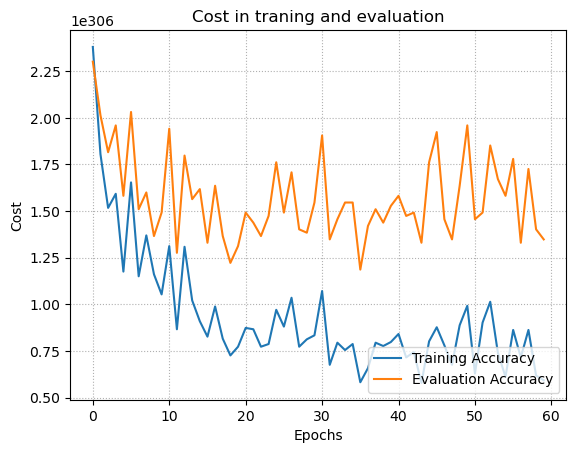

In [10]:
plt.plot(net.training_cost, label='Training Accuracy')
plt.plot(net.evaluation_cost, label='Evaluation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost in traning and evaluation')
plt.grid(True, linestyle=":")
plt.legend(loc="lower right")
plt.show()

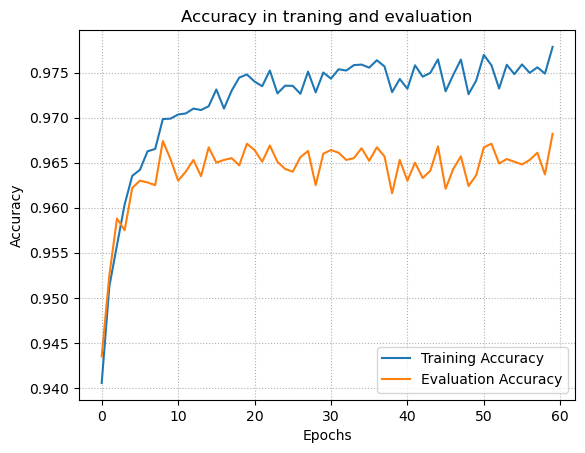

In [11]:
plt.plot(net.training_accuracy, label='Training Accuracy')
plt.plot(net.evaluation_accuracy, label='Evaluation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy in traning and evaluation')
plt.grid(True, linestyle=":")
plt.legend(loc="lower right")
plt.show()

In [16]:
# evaluation accuracy on final epoch
net.evaluation_accuracy[-1]

0.9682